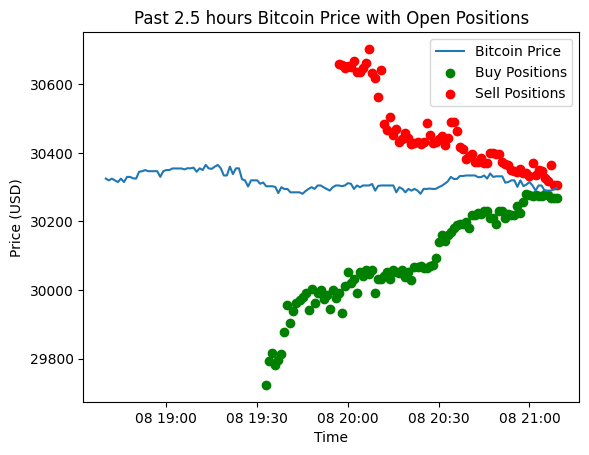

----------------------------------------------
Risk-Reward Analysis | Portfolio Management:
Number of open positions:  170
Number of buy positions:  97
Number of sell positions:  73
Total USDT value of open positions: $ 57.78462729999995
Total BTC value of open positions:  -0.0017100000000000132
Total at risk value of open positions: $ 5.975013099999998
Total reward (i.e. if all open positions closed): $ 5.9750130999995505
Total account value (with current BTC price): $ 1090.26
Total Inventory Balance: $98.9613082733


In [586]:
import csv
import matplotlib.pyplot as plt
import ccxt
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json
import time
import pandas as pd
import numpy as np 
import datetime
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json
# personal modules
from Get_balance import get_total_btc, get_total_usdt
from realtime_price_BTCUSDT_call import get_BTCUSDT_realtime_price
from counter_num_open_positions import count_num_open_positions

#######################################################
# Binance US API initialization
#######################################################

api_key = 'ZxOQ7t6879VgwLQzhxIixxB39iIAUX2355YMjFu1yQzDgUmpquOq3Gyb3XESVJBs'
secret_key = 'tjuC6WfLgKNabCbC21KGJq0uF3XjEzvuXVBU1rPuW7FIrbra4IfOfw4pqILLHT5i'
api_url = "https://api.binance.us"

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

#######################################################
# Get all of the open positions
#######################################################

X_minutes = 150 # plot past X minutes of data

uri_path = "/api/v3/openOrders"
data = {
    "timestamp": int(round(time.time() * 1000))
}

result = binanceus_request(uri_path, data, api_key, secret_key)
result = json.loads(result)

# Open the file in write mode ('w') and create a CSV writer
with open('open_positions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write a header row
    writer.writerow(['Quantity', 'Price', 'Side'])

    # Iterate over the result and write each open position to the file
    for open_position in result:
        quantity = open_position['origQty']
        price = open_position['price']
        side = open_position['side']
        writer.writerow([quantity, price, side])

#######################################################
# Plotting
#######################################################

# Initialize the ccxt exchange
exchange = ccxt.binanceus()
symbol = 'BTC/USDT'
# Fetch past 60 minutes of data
bars = exchange.fetch_ohlcv(symbol, '1m', limit=X_minutes)
# Get closing prices and timestamps
prices = [bar[4] for bar in bars]
timestamps = [bar[0] for bar in bars]
# Convert timestamps to datetime and remove the seconds for cleaner plotting
dates = [datetime.datetime.fromtimestamp(timestamp/1000).replace(second=0, microsecond=0) for timestamp in timestamps]
# Read open positions from file
with open('open_positions.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    open_positions = list(reader)
# Separate buy and sell positions
buy_positions = [float(pos[1]) for pos in open_positions if pos[2] == 'BUY']
sell_positions = [float(pos[1]) for pos in open_positions if pos[2] == 'SELL']
# Create a figure for plotting
fig, ax = plt.subplots()
# Plot the data
ax.plot(dates, prices, label='Bitcoin Price')
if buy_positions:
    ax.scatter(dates[-len(buy_positions):], buy_positions, color='g', label='Buy Positions')
if sell_positions:
    ax.scatter(dates[-len(sell_positions):], sell_positions, color='r', label='Sell Positions')
ax.set_title("Past "+str(X_minutes/60)+" hours Bitcoin Price with Open Positions")
ax.set_xlabel("Time")
ax.set_ylabel("Price (USD)")
ax.legend()
plt.show()

#######################################################
# Risk-Reward Analysis | Portfolio Management
#######################################################

print("----------------------------------------------")
print("Risk-Reward Analysis | Portfolio Management:")

print("Number of open positions: ", len(open_positions))
num_open_positions = len(open_positions)
print("Number of buy positions: ", len(buy_positions))
print("Number of sell positions: ", len(sell_positions))
last_price = prices[-1]

# calculate risk of open positions (quantity * delta_price)
total_usdt_value = 0
total_btc_value = 0
for open_position in open_positions:
    if open_position[2] == "BUY":
        total_usdt_value -= abs((float(open_position[1])) * float(open_position[0]))
        total_btc_value += abs (float(open_position[0]))
    elif open_position[2] == "SELL":
        total_usdt_value += abs((float(open_position[1])) * float(open_position[0]))
        total_btc_value -= abs (float(open_position[0]))

print("Total USDT value of open positions: $", total_usdt_value)
print("Total BTC value of open positions: ", total_btc_value)

# calculate total at risk value of open positions
total_at_risk_value = 0
price_at_the_moment = float(prices[-1])
for open_position in open_positions:
    if open_position[2] == "BUY":
        total_at_risk_value += abs(float(price_at_the_moment-float(open_position[1]))) * float(open_position[0])
    elif open_position[2] == "SELL":
        total_at_risk_value += abs(float(price_at_the_moment-float(open_position[1]))) * float(open_position[0])
print("Total at risk value of open positions: $", total_at_risk_value)
total_reward = abs((total_btc_value * float(prices[-1]))+total_usdt_value)
print("Total reward (i.e. if all open positions closed): $", total_reward)
sharpe_ratio = total_reward / total_at_risk_value
# print("Sharpe ratio (at the moment): ", sharpe_ratio)
moment_price = float(prices[-1])
total_account_value = get_total_btc()*moment_price+get_total_usdt()
print("Total account value (with current BTC price): $", round((total_account_value),2))
main_account_balance_df = pd.read_csv('Deployed_main_account_balance.csv')
print("Total Inventory Balance: $" + str(main_account_balance_df.iloc[-1, 0]))

# extra_dollar = 1000
# extra_btc = 0.3255433
# price_at_12_30am = 30733.14
# initial_hesb_value = 105.24100876840001 + 1000

#######################################################
# Get Trades History (past 1000 trades)
#######################################################

uri_path = "/api/v3/allOrders"
data = {
    "timestamp": int(round(time.time() * 1000)),
    "symbol": "BTCUSDT",
    "limit": 1000,
}

result = binanceus_request(uri_path, data, api_key, secret_key)
result = json.loads(result)

#######################################################
# Save the filled trades (in the past 1000 trades)
#######################################################

# # Open the file in write mode ('w') and create a CSV writer
# with open('filled_trades_history.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     # Write a header row
#     writer.writerow(['Quantity', 'Price', 'Side', 'Time'])

#     # Iterate over the result and write each trade to the file
#     for filled_position in result:

#         if filled_position['status'] == 'FILLED':
#             if filled_position['price'] == '0.00000000':
#                 price = float(filled_position['cummulativeQuoteQty'])/float(filled_position['executedQty']) # divide total traded value in USDT by quantity
#                 quantity = float(filled_position['executedQty'])
#                 side = filled_position['side']
#                 time_trade = filled_position['time']
#                 writer.writerow([quantity, price, side, time_trade])
#             else: 
#                 price = float(filled_position['price'])
#                 quantity = float(filled_position['executedQty'])
#                 side = filled_position['side']
#                 time_trade = filled_position['time']
#                 writer.writerow([quantity, price, side, time_trade])

# # Read trade history from file
# with open('filled_trades_history.csv', 'r') as file:
#     reader = csv.reader(file)
#     next(reader)  # Skip header row
#     filled_positions = list(reader)


#######################################################
# Get Filled Trades in this Run (5:10pm till now)
#######################################################

# # get 5:10pm of July 7th, 2023
# time_run = 1688800500

# # get all trades that have been completed in since the run time
# filled_trades_this_run = []
# for filled_position in filled_positions:
#     quantity = float(filled_position[0])
#     price = float(filled_position[1])
#     side = filled_position[2]
#     time_trade = int(filled_position[3])
#     if time_trade > time_run:
#         filled_trades_this_run.append(filled_position)

#######################################################
# Algorithm's Performance
#######################################################

# print("----------------------------------------------")
# print("Algorithm's Performance:")

# # calculate number of trades
# num_filled_trades_this_run = len(filled_trades_this_run)
# print("Number of filled trades in this run: {} (out of the last 900 fetched trades)".format(num_filled_trades_this_run))
# # Compute average purchase & sale price
# total_purchased = 0
# total_sold = 0
# for position in filled_trades_this_run:
#     quantity = float(position[0])
#     price = float(position[1])
#     side = position[2]
#     if side == 'BUY':
#         total_purchased += quantity * price
#     if side == 'SELL':
#        total_sold += quantity * price
# avg_purchase_price = total_purchased / num_filled_trades_this_run
# print("Average purchase price (filled orders): ${} (out of the last 900 trades)".format(round(avg_purchase_price,5)))
# avg_sale_price = total_sold / num_filled_trades_this_run
# print("Average sale price (filled orders): ${} (out of the last 900 trades)".format(round(avg_sale_price,5)))

# # number of double-trades (SELL-BUY or BUY-SELL) in this deployment
# Deployed_profit_per_trade_predicted_df = pd.read_csv('Deployed_profit_per_trade_predicted.csv')
# Deployed_profit_per_trade_predicted_np = Deployed_profit_per_trade_predicted_df.to_numpy()
# number_of_trades_this_deployment = len(Deployed_profit_per_trade_predicted_np)
# num_double_trades = (num_filled_trades_this_run - num_open_positions)//2
# print("Number of double trades: {} (out of the last {} possible double trades)".format(num_double_trades, number_of_trades_this_deployment//2))
# # Accuracy = round((num_double_trades/(num_double_trades+num_open_positions)),2)
# Accuracy = round((1-num_open_positions/len(Deployed_profit_per_trade_predicted_df)),2)
# print("Number of trades since the lastest deployment: {}".format(number_of_trades_this_deployment))
# print("Accuracy: {} (not considering opened & closing positions by prev. deploy.)".format(Accuracy)) 
# # this accuracy does consdiers the opened positions and currently closing positions made from the previuos
# # deployments as the open positions of the current deployment as well, so it initially is not accurate, but 
# it gets more accurate as the algorithm makes more trades

#######################################################
# Algorithm's Profit
#######################################################

# print("----------------------------------------------")
# print("Algorithm's Profit:")
# print("(assuming all open positions get filled at some point)")

# # calculate total profit (if all open positions get filled at some point)
# total_profit = 0
# for i in range(len(Deployed_profit_per_trade_predicted_np)):
#     total_profit += Deployed_profit_per_trade_predicted_np[i][0]
# print("total profit: ${}".format(total_profit))
# print("profit per trade: ${}".format(round((total_profit/number_of_trades_this_deployment),6)))
# average_time_between_trades = 1 # minutes
# num_trades_per_day = 24*60/average_time_between_trades
# print("exp. profit per day: ${}".format(total_profit/number_of_trades_this_deployment*num_trades_per_day))
# initial_invetsment = 1100
# profit_per_day = total_profit/number_of_trades_this_deployment*num_trades_per_day/initial_invetsment
# print("exp. profit per day: %{}".format(profit_per_day*100))
# print("(assuming "+str(average_time_between_trades)+"min between trades)")
# profit_per_month = (1+profit_per_day)**30
# print("exp. profit per month: %{}".format(round(((profit_per_month)*100-100),1)))
# profit_per_year = (1+profit_per_day)**365
# print("exp. profit per year: %{}".format(round(((profit_per_year)*100-100),1)))

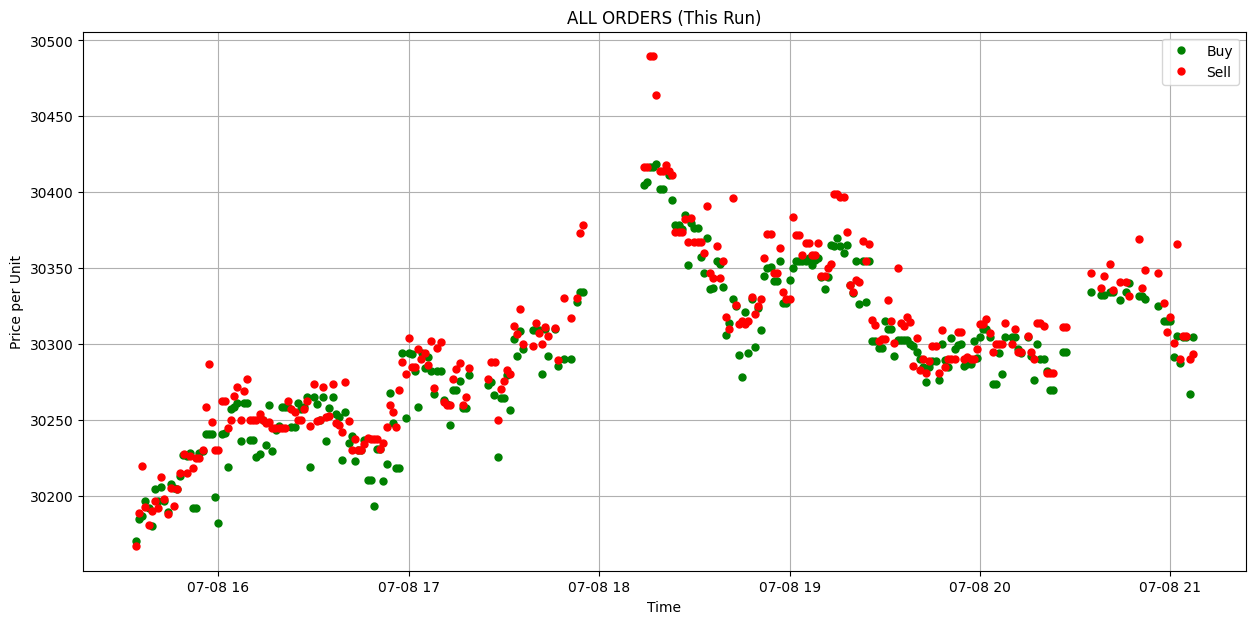

Number of orders that were expired in match:  30
Number of orders that were cancelled:  0
Total Orders: 566
Total Buy Orders: 283
Total Sell Orders: 283
----------------------------------------
Total Units Bought: 0.06513000000000001
Total Units Sold: 0.06588000000000001
Total Spent:$ 1973.5640571000001
Total Earned:$ 1996.8322760000003
Average Buy Price:$ 30301.920115154306
Average Sell Price:$ 30310.143837279906
----------------------------------------
Total Profit:$ 23.268218900000193
(assuming open-orders get closed)
Net Profit:$ 17.293205800000194
(if you close all open-orders now)
----------------------------------------
Average Profit Per Minute:$ 0.04110992738515935
Average Profit Per Day:$ 59.19829543462947
Average Profit Per Minute: (Percent of $1088) 0.003778485972900676
Average Profit Per Minute: (Percent of Spent Value) 0.002083029797652842
Average Profit Per Day:% 5.4410198009769735


In [587]:
import requests
import urllib.parse
import hashlib
import hmac
import time
import csv
import os
import json
import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import pytz

# Read the start time from the csv file
with open('start_time.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        start_time_code = row[0]

# Convert it to a datetime object
start_time_code_dt = datetime.datetime.strptime(start_time_code, "%Y-%m-%d %H:%M:%S.%f")
# print("start_time_code_dt: ", start_time_code_dt)

# Convert to timestamp and use as start_time
start_time_code_ts = int(start_time_code_dt.timestamp() * 1000)
# print("start_time_code: ", start_time_code_ts)

# Convert start_time_code_dt to a timezone-aware datetime object in UTC
pacific = pytz.timezone('US/Pacific')
start_time_code_dt = pacific.localize(start_time_code_dt)
start_time_code_dt = start_time_code_dt.astimezone(pytz.UTC)

# Convert to a timestamp (in milliseconds)
start_time = int(start_time_code_dt.timestamp() * 1000)
end_time = start_time + 24*60*60*1000 # plus 24 hours in milliseconds


api_key = 'LD5eq9nHMz51lvNxA4Yk4Npm02kS09oZU7tdvvkQKpcmLhdoCmUPKEv9xebfHavB'
secret_key = 'DtWIdtZRbtBDzzZPFVVgH39nr3VTNhz7njsb3HHGrYoHJcVl5fB1Jpdc5HoJJTfo'
api_url = "https://api.binance.us"
uri_path = "/api/v3/allOrders"

symbol = 'BTCUSDT'
limit = 1000

data = {
    "timestamp": int(round(time.time() * 1000)),
    "symbol": "BTCUSD"
}

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

#############################################
# Get all orders
#############################################

# Create a DataFrame to hold all data
all_data = pd.DataFrame()

while True:
    data = {
        'symbol': symbol,
        'timestamp': int(round(time.time() * 1000)),
        'limit': limit,
        'startTime': start_time,
        'endTime': end_time
    }

    # print('Fetching orders from', datetime.datetime.fromtimestamp(start_time/1000), 'to', datetime.datetime.fromtimestamp(end_time/1000))

    result = binanceus_request(uri_path, data, api_key, secret_key)
    data = json.loads(result)

    if not isinstance(data, list):
        print('Unexpected response:', data)
        break

    if not data:  # If data is empty, we've fetched all the orders
        break

    # Append new data to all_data DataFrame
    data_df = pd.DataFrame(data)
    all_data = pd.concat([all_data, data_df])

    # Update start_time and end_time for the next request
    start_time = data[-1]['time'] + 1
    end_time = min(int(datetime.datetime.now().timestamp() * 1000), start_time + 24*60*60*1000)  # plus 24 hours or current time whichever is smaller

# print("fetched start time: ", all_data['time'].min()/1000)
# print("fetched end time: ", all_data['time'].max()/1000)
# print("feteched_start_time_dt: ", datetime.datetime.fromtimestamp(all_data['time'].min()/1000))
# print("fetched_end_time_dt: ", datetime.datetime.fromtimestamp(all_data['time'].max()/1000))
# print("start_time_code_ts by 1000: ", start_time_code_ts/1000)

all_data = all_data[all_data['time'] > start_time_code_ts]
all_data.to_csv('All_Orders_ThisRun.csv', index=False)

#############################################
# plot the data
#############################################

# Load the new data
df_new = pd.read_csv('All_Orders_ThisRun.csv')

# Calculate price per unit
df_new['price_per_unit'] = df_new['price']
df_new.loc[df_new['price'] == 0, 'price_per_unit'] = df_new['cummulativeQuoteQty'] / df_new['executedQty']

# Separate buy and sell orders
df_buy_new = df_new[df_new['side'] == 'BUY']
df_sell_new = df_new[df_new['side'] == 'SELL']

# Sort by time
df_buy_new = df_buy_new.sort_values('time')
df_sell_new = df_sell_new.sort_values('time')


# Convert 'time' to datetime and set as index
df_buy_new['time'] = pd.to_datetime(df_buy_new['time'], unit='ms')
df_sell_new['time'] = pd.to_datetime(df_sell_new['time'], unit='ms')

# Localize to UTC and then convert to PST
df_buy_new['time'] = df_buy_new['time'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df_sell_new['time'] = df_sell_new['time'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

df_buy_new.set_index('time', inplace=True)
df_sell_new.set_index('time', inplace=True)

# Plotting code remains the same...

plt.figure(figsize=(15, 7))
plt.plot(df_buy_new.index, df_buy_new['price_per_unit'], 'go', markersize=5, label='Buy')
plt.plot(df_sell_new.index, df_sell_new['price_per_unit'], 'ro', markersize=5, label='Sell')
plt.title('ALL ORDERS (This Run)')
plt.xlabel('Time')
plt.ylabel('Price per Unit')
plt.legend()
plt.grid(True)
plt.show()


#############################################
# calculate the profit
#############################################

print("Number of orders that were expired in match: ", df_new[df_new['status'] == 'EXPIRED_IN_MATCH'].shape[0])
print("Number of orders that were cancelled: ", df_new[df_new['status'] == 'CANCELED'].shape[0])
# Filter out orders with status "EXPIRED_IN_MATCH"
# df_new = df_new[df_new['status'] != 'EXPIRED_IN_MATCH'] 
# Expire in match orders are limit orders and always the seoncd order in a pair of orders.
# (Buy in Shorting and Sell in Buying) 
# I deactived this filter because the profit is lower when I filter out these orders.

# Separate buy and sell orders
df_buy_new = df_new[df_new['side'] == 'BUY']
df_sell_new = df_new[df_new['side'] == 'SELL']

# Calculate potential revenue and cost from open orders
open_sell_revenue = (df_new[(df_new['status'].isin(['PARTIALLY_FILLED', 'NEW'])) & (df_new['side'] == 'SELL')]['origQty'] * df_new[(df_new['status'].isin(['PARTIALLY_FILLED', 'NEW'])) & (df_new['side'] == 'SELL')]['price']).sum()
open_buy_cost = (df_new[(df_new['status'].isin(['PARTIALLY_FILLED', 'NEW'])) & (df_new['side'] == 'BUY')]['origQty'] * df_new[(df_new['status'].isin(['PARTIALLY_FILLED', 'NEW'])) & (df_new['side'] == 'BUY')]['price']).sum()

# calculate the total number of orders
total_orders = len(df_new)
total_buy_orders = len(df_buy_new)
total_sell_orders = len(df_sell_new)

# calculate the total number of units bought and sold
total_units_bought = df_buy_new['executedQty'].sum() + df_new[(df_new['status'].isin(['PARTIALLY_FILLED', 'NEW'])) & (df_new['side'] == 'BUY')]['origQty'].sum()
total_units_sold = df_sell_new['executedQty'].sum() + df_new[(df_new['status'].isin(['PARTIALLY_FILLED', 'NEW'])) & (df_new['side'] == 'SELL')]['origQty'].sum()

# calculate the total amount of money spent and earned
total_spent = df_buy_new['cummulativeQuoteQty'].sum() + open_buy_cost
total_earned = df_sell_new['cummulativeQuoteQty'].sum() + open_sell_revenue

# calculate the average price per unit bought and sold
avg_buy_price = total_spent / total_units_bought
avg_sell_price = total_earned / total_units_sold

# calculate the total profit
total_profit = total_earned - total_spent

# calculate the average profit per unit
avg_profit_per_unit = avg_sell_price - avg_buy_price

# calculate the average profit per order
avg_profit_per_order = total_profit / total_orders

# calculate the average profit per minute (since you're placing an order every minute)
avg_profit_per_minute = total_profit / (total_orders) 
average_profit_per_minute_percent = avg_profit_per_minute / 1088 * 100 # assuming $ 1088 initial account balance
avg_profit_per_minute_percent_of_spent_value = avg_profit_per_minute / total_spent * 100
# calculate the average profit per day
avg_profit_per_day = (avg_profit_per_minute)*1440
avg_profit_per_day_percent = avg_profit_per_day / 1088 * 100 # assuming $ 1088 initial account balance
net_profit_from_start_of_run_till_now = total_profit - total_at_risk_value

# print the results
print('Total Orders:', total_orders)
print('Total Buy Orders:', total_buy_orders)
print('Total Sell Orders:', total_sell_orders)
print("----------------------------------------")
print('Total Units Bought:', total_units_bought)
print('Total Units Sold:', total_units_sold)
print('Total Spent:$', total_spent)
print('Total Earned:$', total_earned)
print('Average Buy Price:$', avg_buy_price)
print('Average Sell Price:$', avg_sell_price)
print("----------------------------------------")  
print("Total Profit:$",  total_profit)
print('(assuming open-orders get closed)')
print("Net Profit:$",  net_profit_from_start_of_run_till_now)
print('(if you close all open-orders now)')
print("----------------------------------------")
# print('Average Profit Per Unit:', avg_profit_per_unit)
# print('Average Profit Per Order:$', avg_profit_per_order)
print('Average Profit Per Minute:$', avg_profit_per_minute)
print('Average Profit Per Day:$', avg_profit_per_day)
print('Average Profit Per Minute: (Percent of $1088)', average_profit_per_minute_percent)
print('Average Profit Per Minute: (Percent of Spent Value)', avg_profit_per_minute_percent_of_spent_value)
print('Average Profit Per Day:%', avg_profit_per_day_percent)


Fetching orders from 2023-07-07 11:00:00 to 2023-07-08 11:00:00
Fetching orders from 2023-07-08 01:57:25.057000 to 2023-07-08 21:09:17.820000
Fetching orders from 2023-07-08 19:33:01.395000 to 2023-07-08 21:09:18.293000
Fetching orders from 2023-07-08 21:07:01.470000 to 2023-07-08 21:09:18.576000


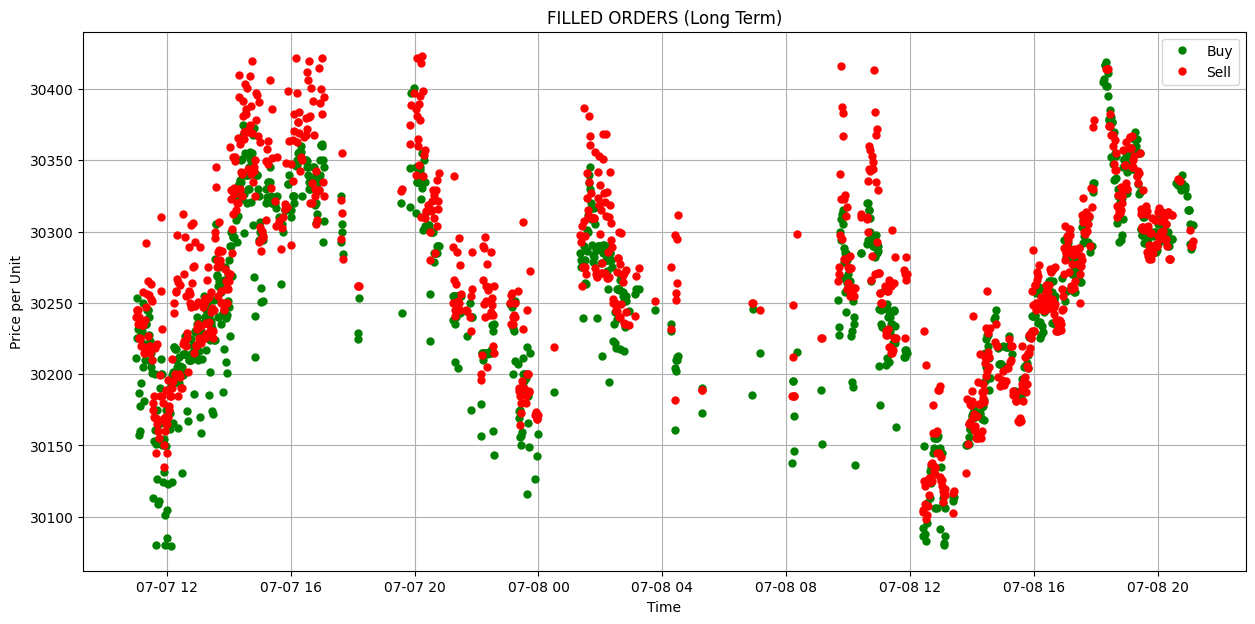

Total Orders (Filled): 1954
Total Buy Orders (Filled): 957
Total Sell Orders (Filled): 997
Total Units Bought (Filled): 0.13963000000000003
Total Units Sold (Filled): 0.13372
Total Spent (Filled):$ 4226.8038648
Total Earned (Filled):$ 4048.0753084
Total Profit (Filled Orders):$ -178.72855640000034
Total Profit (Filled Orders):% -4.228456349451579
Average Buy Price (Filled):$ 30257.95541064331
Average Sell Price (Filled):$ 30270.54760180759
Average Profit Per Unit (Filled): 12.592191164279939
Average Profit Per Order (Filled):$ -0.3564668750942479
Average Profit Per Day (Filled):$ -513.312300135717
Average Profit Per Year (Filled):$ -187358.9895495367


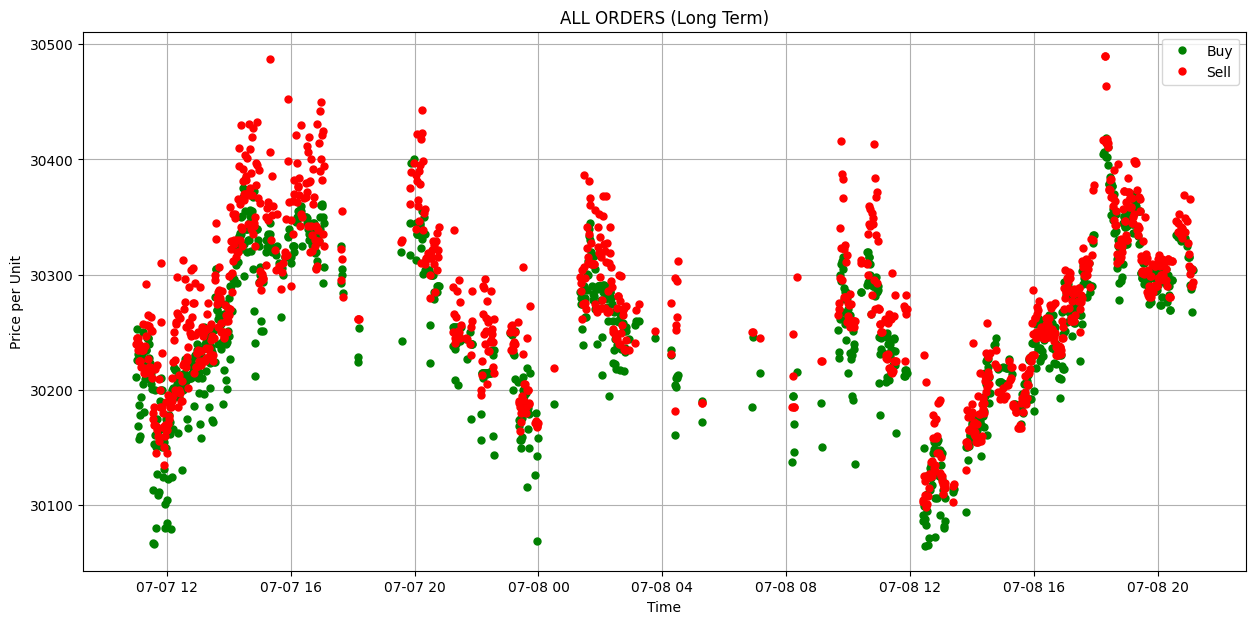

Total Orders: 2145
Total Buy Orders: 1069
Total Sell Orders: 1076
Total Units Bought: 0.14058
Total Units Sold: 0.13393
Total Spent:$ 4255.509904799999
Total Earned:$ 4054.4267651
Total Profit (Filled Orders):$ -201.08313969999926
Total Profit (Filled Orders):% -4.72524196156112
Average Buy Price:$ 30253.916808218568
Average Sell Price:$ 30275.499961897924
Average Profit Per Unit: 21.583153679355746
Average Profit Per Order:$ -0.21277785032819052
Average Profit Per Day:$ -306.40010447259436
Average Profit Per Year:$ -111836.03813249695


In [588]:
import requests
import urllib.parse
import hashlib
import hmac
import time
import csv
import os
import json
import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import pandas as pd

api_key = 'ZxOQ7t6879VgwLQzhxIixxB39iIAUX2355YMjFu1yQzDgUmpquOq3Gyb3XESVJBs'
secret_key = 'tjuC6WfLgKNabCbC21KGJq0uF3XjEzvuXVBU1rPuW7FIrbra4IfOfw4pqILLHT5i'
api_url = "https://api.binance.us"
uri_path = "/api/v3/allOrders"

symbol = 'BTCUSDT'
limit = 1000

data = {
    "timestamp": int(round(time.time() * 1000)),
    "symbol": "BTCUSD"
}

def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

#############################################
# Get all orders
#############################################

# Create a timezone-aware datetime object for the start time in PST
start_time_naive = datetime.datetime(2023, 7, 7, 11, 0)
pacific = pytz.timezone('US/Pacific')
start_time_aware = pacific.localize(start_time_naive)
# Convert to a timestamp (in milliseconds)
start_time = int(start_time_aware.timestamp() * 1000)

end_time = start_time + 24*60*60*1000 # plus 24 hours in milliseconds

# Create a DataFrame to hold all data
all_data = pd.DataFrame()

while True:
    data = {
        'symbol': symbol,
        'timestamp': int(round(time.time() * 1000)),
        'limit': limit,
        'startTime': start_time,
        'endTime': end_time
    }

    print('Fetching orders from', datetime.datetime.fromtimestamp(start_time/1000), 'to', datetime.datetime.fromtimestamp(end_time/1000))

    result = binanceus_request(uri_path, data, api_key, secret_key)
    data = json.loads(result)

    if not isinstance(data, list):
        print('Unexpected response:', data)
        break

    if not data:  # If data is empty, we've fetched all the orders
        break

    # Append new data to all_data DataFrame
    data_df = pd.DataFrame(data)
    all_data = pd.concat([all_data, data_df])

    # Update start_time and end_time for the next request
    start_time = data[-1]['time'] + 1
    end_time = min(int(datetime.datetime.now().timestamp() * 1000), start_time + 24*60*60*1000)  # plus 24 hours or current time whichever is smaller

all_data.to_csv('All_Orders_LONG_TERM.csv', index=False)

#############################################
# Get filled orders
#############################################

# Load all orders from CSV
all_data = pd.read_csv('All_Orders_LONG_TERM.csv')

# Create a new DataFrame to hold only the filled orders
filled_orders = all_data[all_data['status'] == 'FILLED'].copy()

# Convert 'cummulativeQuoteQty' and 'executedQty' columns to float
filled_orders['cummulativeQuoteQty'] = filled_orders['cummulativeQuoteQty'].astype(float)
filled_orders['executedQty'] = filled_orders['executedQty'].astype(float)

# Handle 'price' values as explained in your snippet
filled_orders.loc[filled_orders['price'] == 0.0, 'price'] = filled_orders['cummulativeQuoteQty'] / filled_orders['executedQty']
filled_orders['price'] = filled_orders['price'].astype(float)

# Save the filled orders to a new CSV
filled_orders.to_csv('Filled_Orders_LONG_TERM.csv', index=False)

# Calculate the total values of BUY and SELL orders
buy_orders = filled_orders[filled_orders['side'] == 'BUY']
sell_orders = filled_orders[filled_orders['side'] == 'SELL']

total_buy_value = (buy_orders['price'] * buy_orders['executedQty']).sum()
total_sell_value = (sell_orders['price'] * sell_orders['executedQty']).sum()

#############################################
# plot filled orders
#############################################

# Load the new data
filled_orders_plot = pd.read_csv('Filled_Orders_LONG_TERM.csv')

# Calculate price per unit
filled_orders_plot['price_per_unit'] = filled_orders_plot['price']
filled_orders_plot.loc[filled_orders_plot['price'] == 0, 'price_per_unit'] = filled_orders_plot['cummulativeQuoteQty'] / filled_orders_plot['executedQty']

# Separate buy and sell orders
buy_filled_orders_plot = filled_orders_plot[filled_orders_plot['side'] == 'BUY']
sell_filled_orders_plot = filled_orders_plot[filled_orders_plot['side'] == 'SELL']

# Sort by time
buy_filled_orders_plot = buy_filled_orders_plot.sort_values('time')
sell_filled_orders_plot = sell_filled_orders_plot.sort_values('time')

# Convert 'time' to datetime and set as index
buy_filled_orders_plot['time'] = pd.to_datetime(buy_filled_orders_plot['time'], unit='ms')
sell_filled_orders_plot['time'] = pd.to_datetime(sell_filled_orders_plot['time'], unit='ms')
buy_filled_orders_plot.set_index('time', inplace=True)
sell_filled_orders_plot.set_index('time', inplace=True)
buy_filled_orders_plot.index = buy_filled_orders_plot.index.tz_localize('UTC').tz_convert('US/Pacific')
sell_filled_orders_plot.index = sell_filled_orders_plot.index.tz_localize('UTC').tz_convert('US/Pacific')

buy_filled_orders_plot.head(), sell_filled_orders_plot.head()

# Plot buy and sell orders over time for the new data
plt.figure(figsize=(15, 7))
plt.plot(buy_filled_orders_plot.index, buy_filled_orders_plot['price_per_unit'], 'go', markersize=5, label='Buy')
plt.plot(sell_filled_orders_plot.index, sell_filled_orders_plot['price_per_unit'], 'ro', markersize=5, label='Sell')
plt.title('FILLED ORDERS (Long Term)')
plt.xlabel('Time')
plt.ylabel('Price per Unit')
plt.legend()
plt.grid(True)
plt.show()

#############################################
# calculate the profit (filled orders)
#############################################

# calculate the total number of orders
total_orders_filled = len(filled_orders_plot)
total_buy_orders_filled = len(buy_filled_orders_plot)
total_sell_orders_filled = len(sell_filled_orders_plot)
# calculate the total number of units bought and sold
total_units_bought_filled = buy_filled_orders_plot['executedQty'].sum()
total_units_sold_filled = sell_filled_orders_plot['executedQty'].sum()
# calculate the total amount of money spent and earned
total_spent_filled = buy_filled_orders_plot['cummulativeQuoteQty'].sum()
total_earned_filled = sell_filled_orders_plot['cummulativeQuoteQty'].sum()
# calculate the average price per unit bought and sold
avg_buy_price_filled = buy_filled_orders_plot['price_per_unit'].mean()
avg_sell_price_filled = sell_filled_orders_plot['price_per_unit'].mean()
# calculate the average profit per unit
avg_profit_per_unit_filled = avg_sell_price_filled - avg_buy_price_filled
# calculate the average profit per order
avg_profit_per_order_filled = total_earned_filled/total_sell_orders_filled - total_spent_filled/total_buy_orders_filled
# calculate the average profit per day
avg_profit_per_day_filled = avg_profit_per_order_filled * 24  * 60
# calculate the average profit per year
avg_profit_per_year_filled = avg_profit_per_day_filled * 365
# calculate the average profit per year
avg_profit_per_year_filled = avg_profit_per_day_filled * 365
# print the results
print('Total Orders (Filled):', total_orders_filled)
print('Total Buy Orders (Filled):', total_buy_orders_filled)
print('Total Sell Orders (Filled):', total_sell_orders_filled)
print('Total Units Bought (Filled):', total_units_bought_filled)
print('Total Units Sold (Filled):', total_units_sold_filled)
print('Total Spent (Filled):$', total_spent_filled)
print('Total Earned (Filled):$', total_earned_filled)
print("Total Profit (Filled Orders):$",  total_earned_filled-total_spent_filled)
print("Total Profit (Filled Orders):%", (total_earned_filled-total_spent_filled)/total_spent_filled*100)
print('Average Buy Price (Filled):$', avg_buy_price_filled)
print('Average Sell Price (Filled):$', avg_sell_price_filled)
print('Average Profit Per Unit (Filled):', avg_profit_per_unit_filled)
print('Average Profit Per Order (Filled):$', avg_profit_per_order_filled)
print('Average Profit Per Day (Filled):$', avg_profit_per_day_filled)
print('Average Profit Per Year (Filled):$', avg_profit_per_year_filled)

#############################################
# plot all orders
#############################################

# Load the new data
df_new = pd.read_csv('All_Orders_LONG_TERM.csv')

# Calculate price per unit
df_new['price_per_unit'] = df_new['price']
df_new.loc[df_new['price'] == 0, 'price_per_unit'] = df_new['cummulativeQuoteQty'] / df_new['executedQty']

# Separate buy and sell orders
df_buy_new = df_new[df_new['side'] == 'BUY']
df_sell_new = df_new[df_new['side'] == 'SELL']

# Sort by time
df_buy_new = df_buy_new.sort_values('time')
df_sell_new = df_sell_new.sort_values('time')

# Convert 'time' to datetime and set as index
df_buy_new['time'] = pd.to_datetime(df_buy_new['time'], unit='ms')
df_sell_new['time'] = pd.to_datetime(df_sell_new['time'], unit='ms')
df_buy_new.set_index('time', inplace=True)
df_sell_new.set_index('time', inplace=True)
df_buy_new.index = df_buy_new.index.tz_localize('UTC').tz_convert('US/Pacific')
df_sell_new.index = df_sell_new.index.tz_localize('UTC').tz_convert('US/Pacific')


df_buy_new.head(), df_sell_new.head()

# Plot buy and sell orders over time for the new data
plt.figure(figsize=(15, 7))
plt.plot(df_buy_new.index, df_buy_new['price_per_unit'], 'go', markersize=5, label='Buy')
plt.plot(df_sell_new.index, df_sell_new['price_per_unit'], 'ro', markersize=5, label='Sell')
plt.title('ALL ORDERS (Long Term)')
plt.xlabel('Time')
plt.ylabel('Price per Unit')
plt.legend()
plt.grid(True)
plt.show()

#############################################
# calculate the profit (all orders)
#############################################

# calculate the total number of orders
total_orders = len(df_new)
total_buy_orders = len(df_buy_new)
total_sell_orders = len(df_sell_new)
# calculate the total number of units bought and sold
total_units_bought = df_buy_new['executedQty'].sum()
total_units_sold = df_sell_new['executedQty'].sum()
# calculate the total amount of money spent and earned
total_spent = df_buy_new['cummulativeQuoteQty'].sum()
total_earned = df_sell_new['cummulativeQuoteQty'].sum()
# calculate the average price per unit bought and sold
avg_buy_price = df_buy_new['price_per_unit'].mean()
avg_sell_price = df_sell_new['price_per_unit'].mean()
# calculate the average profit per unit
avg_profit_per_unit = avg_sell_price - avg_buy_price
# calculate the average profit per order
avg_profit_per_order = total_earned/total_sell_orders - total_spent/total_buy_orders
# calculate the average profit per day
avg_profit_per_day = avg_profit_per_order * 24  * 60
# calculate the average profit per year
avg_profit_per_year = avg_profit_per_day * 365
# calculate the average profit per year
avg_profit_per_year = avg_profit_per_day * 365
# print the results
print('Total Orders:', total_orders)
print('Total Buy Orders:', total_buy_orders)
print('Total Sell Orders:', total_sell_orders)
print('Total Units Bought:', total_units_bought)
print('Total Units Sold:', total_units_sold)
print('Total Spent:$', total_spent)
print('Total Earned:$', total_earned)
print("Total Profit (Filled Orders):$",  total_earned-total_spent)
print("Total Profit (Filled Orders):%", (total_earned-total_spent)/total_spent*100)
print('Average Buy Price:$', avg_buy_price)
print('Average Sell Price:$', avg_sell_price)
print('Average Profit Per Unit:', avg_profit_per_unit)
print('Average Profit Per Order:$', avg_profit_per_order)
print('Average Profit Per Day:$', avg_profit_per_day)
print('Average Profit Per Year:$', avg_profit_per_year)


In [589]:
# inventory calculation
num_trades_needed_to_keep_up_with_market = 200 
# 1/profit_per_day # 1/0.007 = 142.8 => 150 each side
# MAX_NUM_ORDERS = 200 by Binance => 100 each side
position_ratio = 1/num_trades_needed_to_keep_up_with_market # 1/100 = 0.01
min_tradable_amount_usdt = 3 # in USD: 0.0001 BTC at 30k BTC price
min_value_needed_to_keep_up_with_market = min_tradable_amount_usdt/position_ratio # 300 USD
# the initial USDT in the account was $50 or less, to adjust for this, I changed position 
# ratio of longing (usdt) to 0.05 which is equivalent to having $250 in the account
# I'm concenrned about this tho since I see that sometimes it's not enough and I see
# that the algorithm is not buying when it can, so I might need to increase this number later

min_tradable_amount_btc = 0.0001 # in BTC
min_value_needed_to_keep_up_with_market_btc = min_tradable_amount_btc/position_ratio # 0.01 BTC
